In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

This image is: <class 'numpy.ndarray'> with dimension: (540, 960, 3)


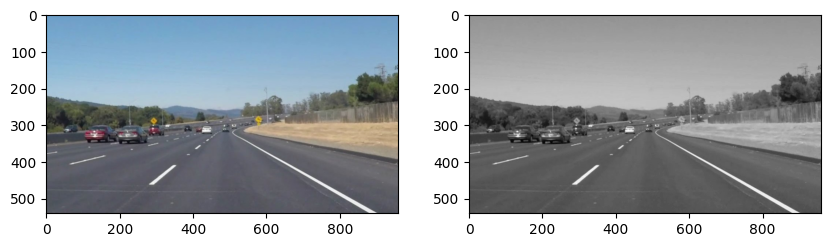

In [16]:
image = cv2.imread('/home/veeransh/Desktop/self-driven-car-ai/Data/straight_line.png')
print('This image is:', type(image), 'with dimension:', image.shape)
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap = 'gray')
plt.show()

In [17]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

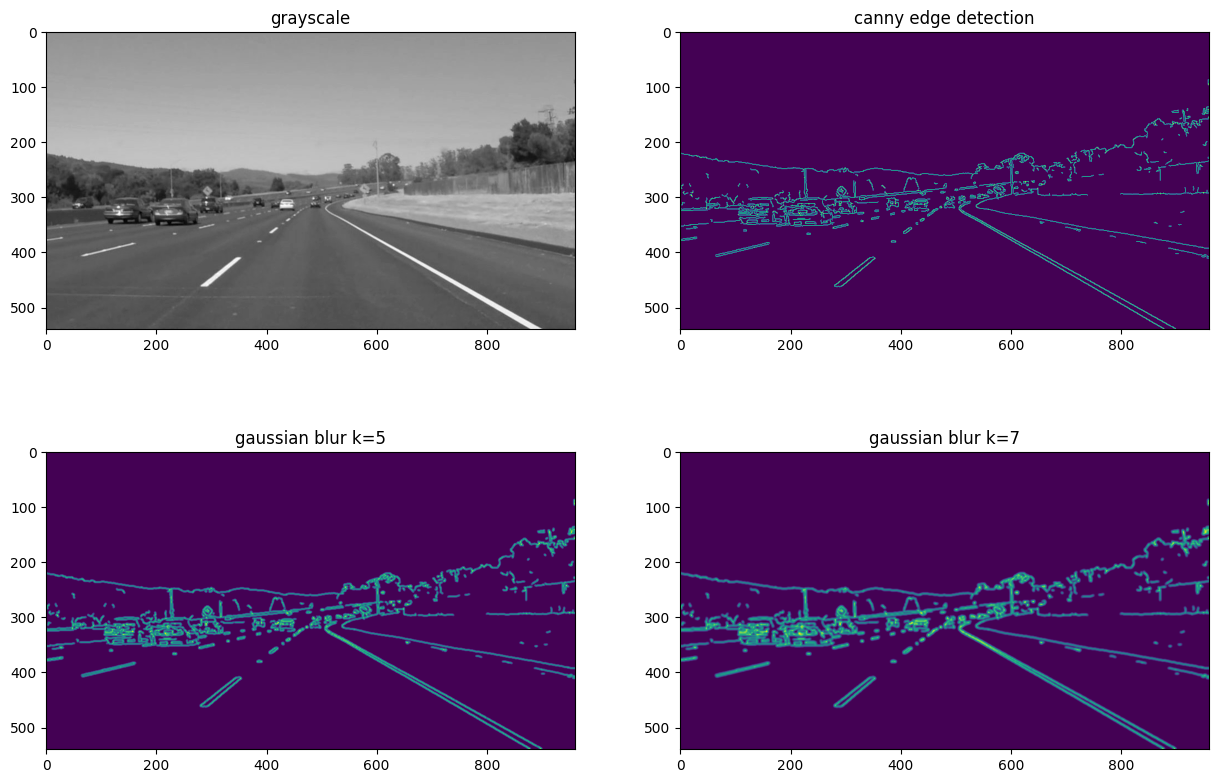

In [18]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
plt.imshow(grayscale(image), cmap = 'gray')
plt.title('grayscale')

plt.subplot(2, 2, 2)
plt.imshow(canny(image, 100, 150))
plt.title('canny edge detection')

plt.subplot(2, 2, 3)
plt.imshow(gaussian_blur(canny(image, 100, 150), 5))
plt.title('gaussian blur k=5')

plt.subplot(2, 2, 4)
plt.imshow(gaussian_blur(canny(image, 100, 150), 7))
plt.title('gaussian blur k=7')

plt.show()

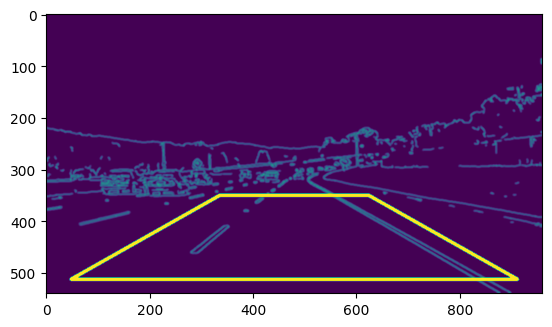

In [19]:
blurred = gaussian_blur(canny(image, 100, 150), 7)
rows, cols = image.shape[:2]
bottom_left  = [int(cols*0.05), int(rows*0.95)]
top_left     = [int(cols*0.35), int(rows*0.65)]
bottom_right = [int(cols*0.95), int(rows*0.95)]
top_right    = [int(cols*0.65), int(rows*0.65)]
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

copied = np.copy(blurred)
cv2.line(copied,tuple(bottom_left),tuple(bottom_right), (255, 0, 0), 5)
cv2.line(copied,tuple(bottom_right),tuple(top_right), (255, 0, 0), 5)
cv2.line(copied,tuple(top_left),tuple(bottom_left), (255, 0, 0), 5)
cv2.line(copied,tuple(top_left),tuple(top_right), (255, 0, 0), 5)
plt.imshow(copied)
plt.show()

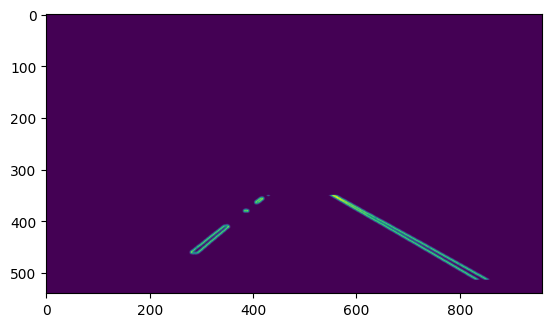

In [20]:
copied = np.copy(blurred)
plt.imshow(region_of_interest(copied,vertices))
plt.show()

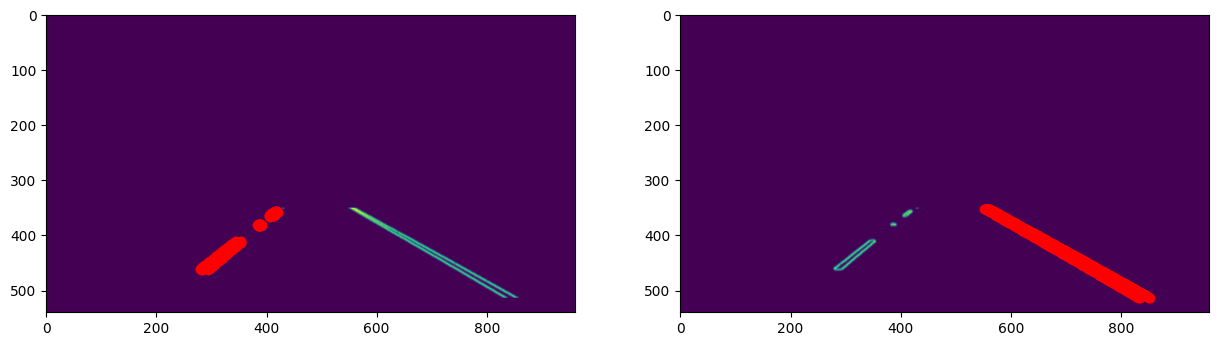

In [21]:
interested = region_of_interest(copied,vertices)
plt.figure(figsize = (15, 10))
plt.subplot(1,2,1)
where_left = np.where(interested[:,:interested.shape[1]//2] > 80)
plt.imshow(interested)
plt.scatter(where_left[1],where_left[0],color='r')
plt.subplot(1,2,2)
where_right = np.where(interested[:,interested.shape[1]//2:] > 80)
plt.imshow(interested)
plt.scatter(where_right[1]+interested.shape[1]//2,where_right[0],color='r')
plt.show()

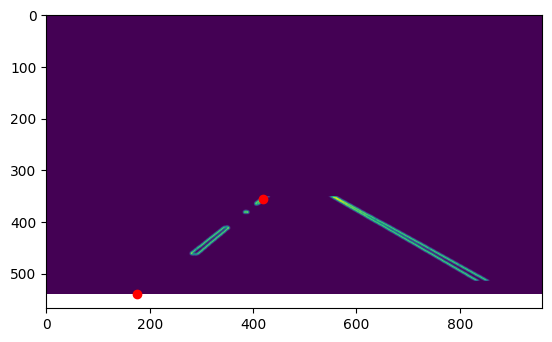

In [22]:
dot_top_left = [np.max(where_left[1]),np.min(where_left[0])]
pseudo_bottom_left = [np.min(where_left[1]),np.max(where_left[0])]
m_left, c_left = np.polyfit([pseudo_bottom_left[1],dot_top_left[1]],
                           [pseudo_bottom_left[0],dot_top_left[0]],1)
dot_bottom_left = [int(image.shape[0]*m_left+c_left),image.shape[0]]
plt.imshow(interested)
plt.scatter(np.max(where_left[1]),np.min(where_left[0]),color='r')
plt.scatter(int(image.shape[0]*m_left+c_left),image.shape[0],color='r')
plt.show()

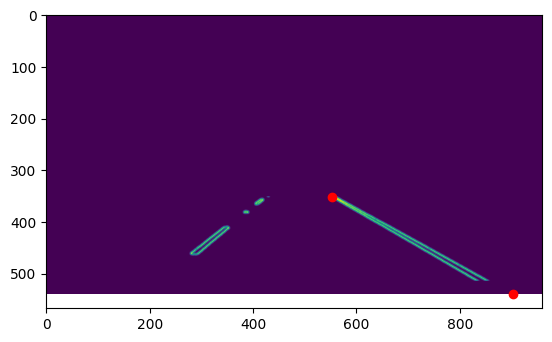

In [23]:
dot_top_right = [image.shape[1]//2+np.min(where_right[1]),np.min(where_right[0])]
pseudo_bottom_right = [image.shape[1]//2+np.max(where_right[1]),np.max(where_right[0])]
m_right, c_right = np.polyfit([pseudo_bottom_right[1],dot_top_right[1]],
                           [pseudo_bottom_right[0],dot_top_right[0]],1)
dot_bottom_right = [int(image.shape[0]*m_right+c_right),image.shape[0]]
plt.imshow(interested)
plt.scatter(image.shape[1]//2+np.min(where_right[1]),np.min(where_right[0]),color='r')
plt.scatter(int(image.shape[0]*m_right+c_right),image.shape[0],color='r')
plt.show()

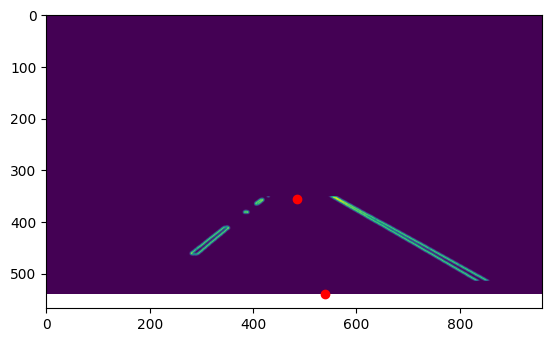

In [24]:
middle_top = [int(dot_top_left[0]+((dot_top_right[0]-dot_top_left[0])/2)),dot_top_left[1]]
middle_bottom = [int(dot_bottom_left[0]+((dot_bottom_right[0]-dot_bottom_left[0])/2)),image.shape[0]]
plt.imshow(interested)
plt.scatter(middle_top[0],middle_top[1],color='r')
plt.scatter(middle_bottom[0],middle_bottom[1],color='r')
plt.show()

In [25]:
# we need to calculate the distance between middle bottom with center of screen
steering_val = middle_bottom[0] - image.shape[1] //2
if steering_val > 0:
    steering_string = 'right about: %.2fm'%(np.abs(steering_val/100))
else:
    steering_string = 'left about: %.2fm'%(np.abs(steering_val/100))


In [26]:
plt.figure(figsize = (15, 7))
copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
window_img = np.zeros_like(copied)    
polyfill = np.array([bottom_left,bottom_right,top_right,top_left])
cv2.fillPoly(window_img, pts =[polyfill], color=(0,255, 0))
copied = cv2.addWeighted(copied, 1, window_img, 0.3, 0)
cv2.line(copied,tuple(dot_top_left),tuple(dot_bottom_left),(255,0,0),5)
cv2.line(copied,tuple(dot_top_right),tuple(dot_bottom_right),(255,0,0),5)
cv2.line(copied,tuple(middle_top),tuple(middle_bottom),(255,255,255),1)

pil_image = Image.fromarray(np.uint8(copied))
draw = ImageDraw.Draw(pil_image)
font = ImageFont.truetype('Roboto-Regular.ttf', 40)
draw.text((10, 10),steering_string,fill='white',font=font)

plt.imshow(np.array(pil_image))
plt.show()

OSError: cannot open resource

<Figure size 1500x700 with 0 Axes>